In [87]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, make_scorer, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score, cross_val_predict
from sklearn import tree
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split

In [88]:
# read data
with open('wdbc.pkl', 'rb') as f:
    data = pickle.load(f)

# _0:   mean of sample
# _1:   std of sample
# _2:   "worst" of sample

data = data.sample(frac=1).reset_index(drop=True)
data.head()

,id,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
0,902975,0,12.210,14.09,78.78,462.0,0.08108,0.07823,0.068390,0.025340,...,13.13,19.29,87.65,529.9,0.10260,0.24310,0.30760,0.09140,0.2677,0.08824
1,905978,0,9.405,21.70,59.60,271.2,0.10440,0.06159,0.020470,0.012570,...,10.85,31.24,68.73,359.4,0.15260,0.11930,0.06141,0.03770,0.2872,0.08304
2,893526,0,13.500,12.71,85.69,566.2,0.07376,0.03614,0.002758,0.004419,...,14.97,16.94,95.48,698.7,0.09023,0.05836,0.01379,0.02210,0.2267,0.06192
3,87556202,1,14.860,23.21,100.40,671.4,0.10440,0.19800,0.169700,0.088780,...,16.08,27.78,118.60,784.7,0.13160,0.46480,0.45890,0.17270,0.3000,0.08701
4,874158,0,10.080,15.11,63.76,317.5,0.09267,0.04695,0.001597,0.002404,...,11.87,21.18,75.39,437.0,0.15210,0.10190,0.00692,0.01042,0.2933,0.07697


### **1. Rule based classifier**

We want to create a rule based classifier based on a number of factors which make tumor cells stand out among regular tissue. These factors can be summarized as:
1. Signiﬁcantly **larger** cells are indicative of malignant tumors.
2. Malignant cells can develop **arbitrary structures** that do not conform with the general pattern of their surroundings.
3. Malignant cells often have signiﬁcantly **larger and darker nuclei** that are more densely packed with DNA. 
4. Malignant cells can range from **smooth surfaces to ragged or lumpy textures** for neighbouring cells. 
5. Cancer cells tend to **spread out or clutter** almost arbitrarily.

In our dataset we have 10 variables describing each cell. The three different features for each variable, with suffixes "_0", "_1", "_2" represent the mean, standard deviation and "worst" value over a set of samples, respectively.


The following variables describe size:
- Radius
- Perimeter
- Area

The following variables describe shape: 
- Compactness
- Perimeter
- Concavity
- Smothness
- Concave points
- Symmetry
- Fractal dimension

The following variable describe texture:
- Texture 

**Steps:**
1. Feature selection - find features that contribute most to the target variable 
    - Using *SelectKBest* with f_classif score function
    - Creating correlation matrices
2. Finding threshold values for each of the used features. 
3. Implementing the rule based classifier based on threshold values. 

**Feature selection**

As we have many variables describing both size and shape, we want to select some of these features. One approach is using SelectKBest with f_classif. Uses ANOVA F-value between label/feature for classification tasks. 

In [89]:
X = data.drop(['malignant','id'], axis=1)
Y = data['malignant']

# get k best features 

k = 5
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, Y)

k_best_features = selector.get_feature_names_out()
print(f'The {k} best features are: {k_best_features}')

The 5 best features are: ['perimeter_0' 'concave points_0' 'radius_2' 'perimeter_2'
 'concave points_2']


The five "best" (most important) features are
1. concave points_2 (worst of concave point)
2. perimeter_2 (worst of perimeter)
3. radius_2 (worst of radius)
4. concave points_0 (mean of concave point)
5. perimeter_0 (mean of perimeter)

In [90]:
# all data with benign cells
data_benign = data[data['malignant'] == 0]

# provides descriptions of each of the features in the dataset
data_benign.describe(percentiles=[0.25, 0.5, 0.75, 0.8])

,id,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
count,3.570000e+02,357.0,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,2.654382e+07,0.0,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
std,1.167397e+08,0.0,1.780512,3.995125,11.807438,134.287118,0.013446,0.033750,0.043442,0.015909,...,1.981368,5.493955,13.527091,163.601424,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804
min,8.913000e+03,0.0,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210
25%,8.746620e+05,0.0,11.080000,15.150000,70.870000,378.200000,0.083060,0.055620,0.020310,0.015020,...,12.080000,19.580000,78.270000,447.100000,0.110400,0.112000,0.077080,0.051040,0.240600,0.070090
50%,9.089160e+05,0.0,12.200000,17.390000,78.180000,458.400000,0.090760,0.075290,0.037090,0.023440,...,13.350000,22.820000,86.920000,547.400000,0.125400,0.169800,0.141200,0.074310,0.268700,0.077120
75%,8.812816e+06,0.0,13.370000,19.760000,86.100000,551.100000,0.100700,0.097550,0.059990,0.032510,...,14.800000,26.510000,96.590000,670.000000,0.137600,0.230200,0.221600,0.097490,0.298300,0.085410
80%,8.912831e+06,0.0,13.648000,20.668000,87.872000,572.200000,0.103260,0.106800,0.067348,0.037088,...,15.050000,27.860000,98.394000,697.840000,0.141160,0.250460,0.245260,0.102420,0.305980,0.088390
max,9.113205e+08,0.0,17.850000,33.810000,114.600000,992.100000,0.163400,0.223900,0.410800,0.085340,...,19.820000,41.780000,127.100000,1210.000000,0.200600,0.584900,1.252000,0.175000,0.422800,0.148600


**Cell size**

Here, we look at a correlation matrix for all features that measures cell size. 

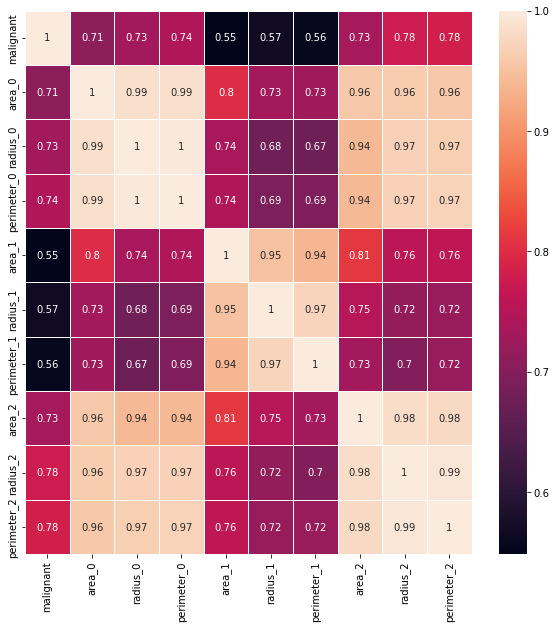

In [91]:
cell_size_feat = data[['malignant', 
                        'area_0' ,'radius_0', 'perimeter_0',
                        'area_1' ,'radius_1', 'perimeter_1',
                        'area_2' ,'radius_2', 'perimeter_2', ]]

fig, ax = plt.subplots(figsize=(10,10))         
cm_cell_size = cell_size_feat.corr()
sn.heatmap(cm_cell_size, annot=True, linewidths=.5, ax=ax)
plt.show()

116.88063635084741


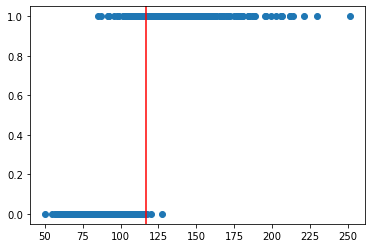

In [139]:
mean_perimeter_75 = data_benign['perimeter_2'].describe().loc['75%']
mean_perimeter_std = data_benign['perimeter_2'].describe().loc['std']

size_threshold = mean_perimeter_75 + 1.5 * mean_perimeter_std
print(size_threshold)

perimeter_0 = data['perimeter_2']
plt.scatter(perimeter_0, Y)
plt.axvline(size_threshold, 0, 1, c='r')
plt.show()

From looking at this correlation matrix, we can see that the feature perimeter_2, worst perimeter, along with the feature radius_2, the worst radius, has the largest correlation with the feature malignant.

We therefore decide to find a threshold value for the worst perimeter, and use this to determine if a cell is "significantly larger" than a normal cell. The threshold we decided on is if the worst perimeter is two standard deviations larger than the 75th percentile. 

**Cell shape**

Perimeter can decide the shape, but as we already have looked at it we here inspect the other features that determine shape: compactness, smoothness, concavity, concave points, symmetry and fractal dimension. 
We look at a correlation matrix for all these features.

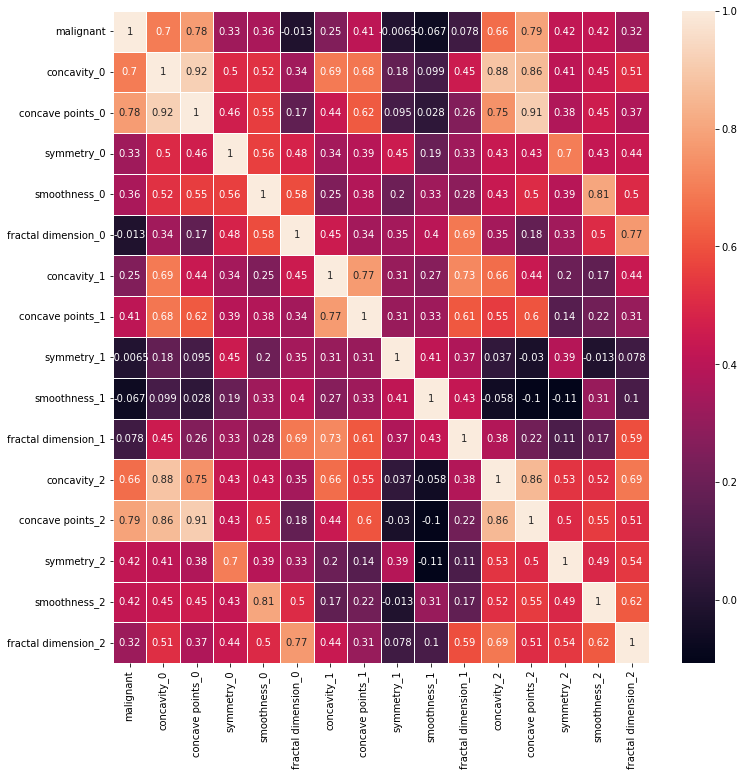

In [93]:
cell_shape_features = data[['malignant', 'concavity_0' ,'concave points_0', 
                    'symmetry_0', 'smoothness_0', 'fractal dimension_0',
                    'concavity_1' ,'concave points_1', 
                    'symmetry_1', 'smoothness_1', 'fractal dimension_1',
                    'concavity_2' ,'concave points_2', 
                    'symmetry_2', 'smoothness_2', 'fractal dimension_2']]


fig, ax = plt.subplots(figsize=(12,12))         
cm_cell_shape = cell_shape_features.corr()
sn.heatmap(cm_cell_shape, annot=True, linewidths=.6, ax=ax)
plt.show()


We select to use "concave points_2" as the feature to measure shape. As with the cell size, we set the threshold to be two standard deviations larger than the 75th percentile of the feature.  

The threshold value for the feature 'concave points_2' is 0.15118606066344334


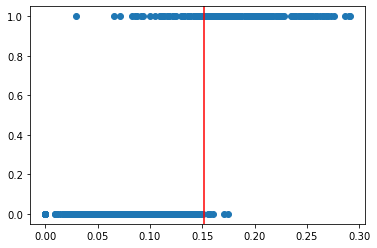

In [94]:
mean_concave_points_75 = data_benign['concave points_2'].describe().loc['75%']
mean_concave_points_std = data_benign['concave points_2'].describe().loc['std']

shape_threshold = mean_concave_points_75 + 1.5 * mean_concave_points_std
print(f'The threshold value for the feature \'concave points_2\' is {shape_threshold}')

concave_points = data['concave points_2']
labels = data['malignant']

plt.scatter(concave_points, labels) 
plt.axvline(shape_threshold, 0, 1, c='r')
plt.show()

**Cell Texture**

Texture is the feature that measures the texture of the cell. We again look at a heatmap of the three versions of the feature. 

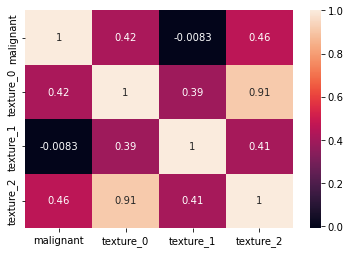

In [95]:
cell_texture_features = data[['malignant', 'texture_0', 'texture_1' ,'texture_2']]

cm_texture = cell_texture_features.corr()
sn.heatmap(cm_texture, annot=True)
plt.show()

We select to use "texture_2" as the feature to measure texture. We again set the threshold to be two standard deviations larger than the 75th percentile of the feature.  

The threshold value for the feature 'texture_2' is 34.75093178456416


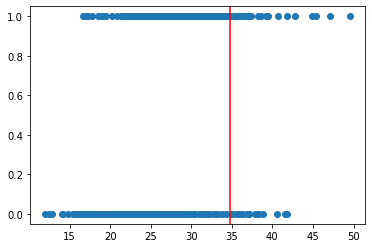

In [96]:
mean_texture_75 = data_benign['texture_2'].describe().loc['75%']
mean_texture_std = data_benign['texture_2'].describe().loc['std']

texture_threshold = mean_texture_75 + 1.5 * mean_texture_std
print(f'The threshold value for the feature \'texture_2\' is {texture_threshold}')

texture = data['texture_2']
labels = data['malignant']

plt.scatter(texture, labels)
plt.axvline(texture_threshold, 0, 1, c='r')
plt.show()

Accuracy score: 0.9244
F1 score: 0.9002
ROC AUC score: 0.9225


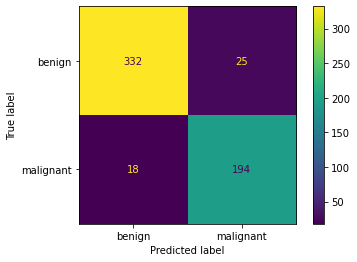

In [138]:
def rulebased_classifier(X):
    predictions = []
    for _, x in X.iterrows():
        if x['perimeter_2'] > size_threshold or x['concave points_2'] > shape_threshold or x['texture_2'] > texture_threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def scores(y_true, predictions):
    acc = accuracy_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    roc_auc = roc_auc_score(y_true, predictions)
    print(f"Accuracy score: {round(acc, 4)}")
    print(f"F1 score: {round(f1, 4)}")
    print(f"ROC AUC score: {round(roc_auc, 4)}")
    return acc, f1

test = data.drop(['malignant'], axis=1)
y_true = data['malignant']

pred = rulebased_classifier(test)
acc, f1 = scores(y_true, pred)

cm = confusion_matrix(y_true, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot()

plt.show()

### **2. Random forest classifier using the sklearn framework**

In [128]:
scoring = {'accuracy': make_scorer(accuracy_score), 
           'f1': make_scorer(f1_score, pos_label='1'), 
            }

# Parameters to examine
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 40, 70, 100, 200, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10, 15, 20],
    'n_estimators': [5, 10, 20, 30]
 }

rf = RandomForestClassifier()

X = data.drop(['malignant','id'], axis=1)
Y = data['malignant']

# Perform grid search
rf_cv = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring=['accuracy', 'f1', 'roc_auc'],  refit='f1')
rf_cv.fit(X, Y)

Tuned hyperparameters:  {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}
F1 score: mean_fit_time                                                       0.041316
std_fit_time                                                        0.007718
mean_score_time                                                     0.006234
std_score_time                                                      0.001759
param_bootstrap                                                        False
param_max_depth                                                          100
param_min_samples_leaf                                                     1
param_min_samples_split                                                   10
param_n_estimators                                                        20
params                     {'bootstrap': False, 'max_depth': 100, 'min_sa...
split0_test_accuracy                                                0.964912
split1_test_

In [135]:
results_rf_cv = pd.DataFrame(rf_cv.cv_results_)

print("Tuned hyperparameters: ", rf_cv.best_params_)
print("Mean F1 score:", results_rf_cv.loc[rf_cv.best_index_]['mean_test_f1'])
print("Mean accuracy score:", results_rf_cv.loc[rf_cv.best_index_]['mean_test_accuracy'])
print("Mean ROC AUC score:", results_rf_cv.loc[rf_cv.best_index_]['mean_test_roc_auc'])

Tuned hyperparameters:  {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}
Mean F1 score: 0.9553498022941707
Mean accuracy score: 0.9666356155876417
Mean ROC AUC score: 0.9906050861586401


Accuracy score: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


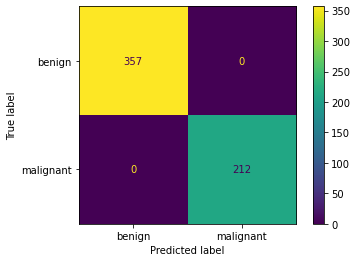

In [123]:
preds = rf_cv.predict(X)

acc = accuracy_score(y_true, preds)
print('Accuracy score:', acc)

acc = f1_score(y_true, preds)
print('F1 Score:', acc)

acc = roc_auc_score(y_true, preds)
print('ROC AUC Score:', acc)

cm_rf = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['benign', 'malignant'])
disp.plot()
plt.show()

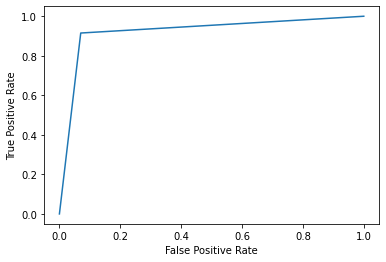

In [99]:
#define metrics
fpr, tpr, _ = roc_curve(y_true, pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### **3. Classifier of our own design which attempts to trade off interpretability and classification performance**

In [133]:
param_grid = {  
                'max_depth': [2, 3, 5],
                'min_samples_leaf': [1, 2, 3, 5, 7, 10, 20]
            }


X = data[['radius_0', 'perimeter_0', 'area_0', 'concavity_0', 'concave points_0', 'radius_2', 'perimeter_2', 'area_2', 'concavity_2','concave points_2', 'texture_2', 'texture_0']]


dt = DecisionTreeClassifier()
dt_cv = GridSearchCV(dt, param_grid, cv=5, n_jobs=-1, scoring=['accuracy', 'f1', 'roc_auc'],  refit='f1')
dt_cv.fit(X, Y)

print("Tuned hyperparameters: (best parameters)", dt_cv.best_params_)
print("f1 score:", round(dt_cv.best_score_, 4))

Tuned hyperparameters: (best parameters) {'max_depth': 5, 'min_samples_leaf': 5}
f1 score: 0.9201


In [136]:
results_dt_cv = pd.DataFrame(dt_cv.cv_results_)

print("F1 score:", results_dt_cv.loc[dt_cv.best_index_]['mean_test_f1'])
print("F1 score:", results_dt_cv.loc[dt_cv.best_index_]['mean_test_accuracy'])
print("F1 score:", results_dt_cv.loc[dt_cv.best_index_]['mean_test_roc_auc'])

F1 score: 0.9200798235590171
F1 score: 0.9420121099208197
F1 score: 0.9481225206536376


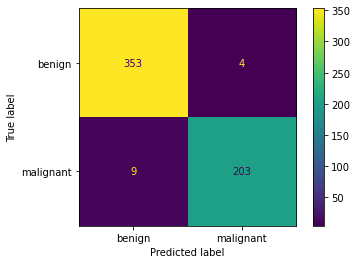

In [101]:
preds = dt_cv.predict(X)

cm_dt = confusion_matrix(y_true, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['benign', 'malignant'])
disp.plot()
plt.show()

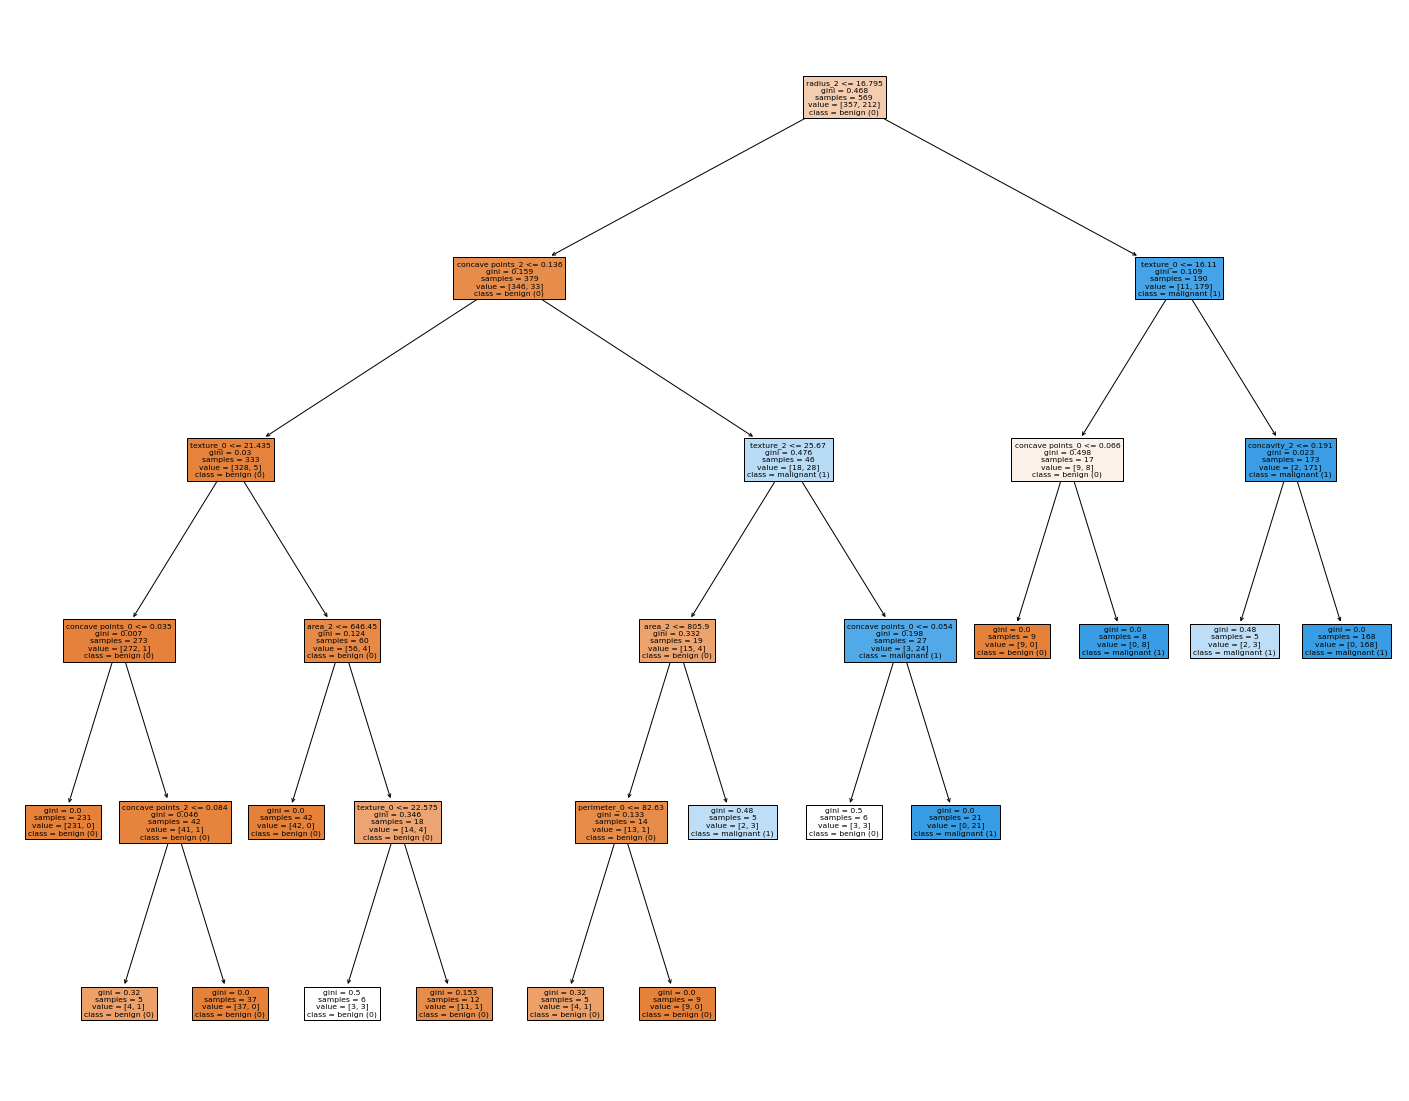

In [102]:
class_names = ['benign (0)', 'malignant (1)']

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_cv.best_estimator_, 
                   feature_names=dt_cv.feature_names_in_,  
                   class_names=class_names,
                   filled=True)


## 2D Logistic Regression

In [103]:
X_selected = data[['perimeter_2', 'concave points_2']]
scaler = preprocessing.MinMaxScaler()
scaled_X_selected = pd.DataFrame(scaler.fit_transform(X_selected), columns=['perimeter_2', 'concave points_2'])

lgr = LogisticRegression()

k = 5
lgr_cross_val = cross_validate(lgr, scaled_X_selected, Y, cv=k)
mean_lgr_score = lgr_cross_val['test_score'].mean()
print(f'Mean accuracy score for cross validation with {k} folds: {round(mean_lgr_score, 5)}')

Mean accuracy score for cross validation with 5 folds: 0.93501


In [104]:
X_selected = data[['perimeter_2', 'concave points_2']]

X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.2, random_state=42)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

# Scale the data
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=['perimeter_2', 'concave points_2'])
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=['perimeter_2', 'concave points_2'])

scaled_X_train.index = X_train.index
scaled_X_test.index = X_test.index

lgr = LogisticRegression()

lgr.fit(scaled_X_train, y_train)
y_pred = lgr.predict(scaled_X_test)

acc_lgr = accuracy_score(y_test, y_pred)

print(acc_lgr)


0.9210526315789473


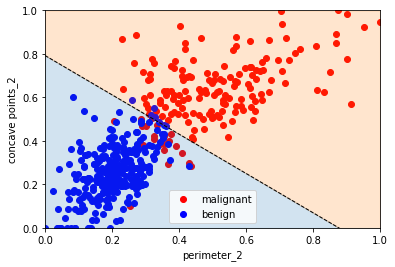

In [105]:
# Create scatter plot
fig, ax = plt.subplots()
red_points = ax.scatter(scaled_X_train.loc[Y==1, 'perimeter_2'], scaled_X_train.loc[Y==1, 'concave points_2'], color='red')
blue_points = ax.scatter(scaled_X_train.loc[Y==0, 'perimeter_2'], scaled_X_train.loc[Y==0, 'concave points_2'], color='blue')

# Add legend
ax.legend((red_points, blue_points), ('malignant', 'benign'))

# Add axis labels and title
ax.set_xlabel('perimeter_2')
ax.set_ylabel('concave points_2')

# Retrieve the model parameters
b = lgr.intercept_[0]
w1, w2 = lgr.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary
xmin, xmax = 0, 1
ymin, ymax = 0, 1
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Show plot
plt.show()

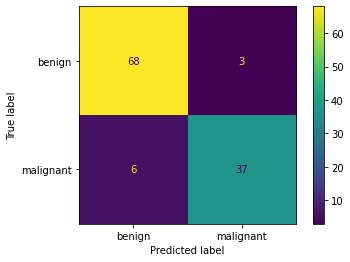

In [106]:
cm_lgr = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgr, display_labels=['benign', 'malignant'])
disp.plot()
plt.show()

## 3D LOGISTIC REGRESSION

In [107]:
X_selected = data[['perimeter_2', 'concave points_2', 'texture_2']]
scaler = preprocessing.MinMaxScaler()
scaled_X_selected = pd.DataFrame(scaler.fit_transform(X_selected), columns=['perimeter_2', 'concave points_2', 'texture_2'])

lgr = LogisticRegression()

k = 5
lgr_cross_val = cross_validate(lgr, scaled_X_selected, Y, cv=k)
mean_lgr_score = lgr_cross_val['test_score'].mean()
print(f'Mean accuracy score for cross validation with {k} folds: {round(mean_lgr_score, 5)}')

Mean accuracy score for cross validation with 5 folds: 0.95435


In [108]:

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.2, random_state=42)

# Scale the data
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=['perimeter_2', 'concave points_2', 'texture_2'])
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=['perimeter_2', 'concave points_2', 'texture_2'])

scaled_X_train.index = X_train.index
scaled_X_test.index = X_test.index

lgr = LogisticRegression()
lgr.fit(scaled_X_train, y_train)
y_pred = lgr.predict(scaled_X_test)

acc_lgr = accuracy_score(y_test, y_pred)

print(acc_lgr)

0.956140350877193


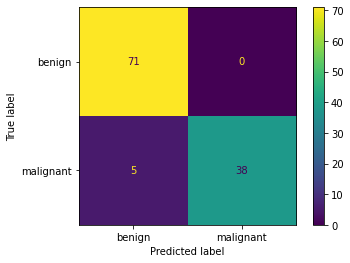

In [109]:
cm_lgr = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgr, display_labels=['benign', 'malignant'])
disp.plot()
plt.show()

## Plotting

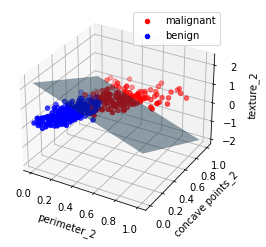

In [110]:
from mpl_toolkits.mplot3d import Axes3D

# create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('perimeter_2')
ax.set_ylabel('concave points_2')
ax.set_zlabel('texture_2') 

# Define grid for plotting the decision boundary
x1_grid, x2_grid = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
x3_grid = (0.5 - lgr.intercept_ - lgr.coef_[0,0]*x1_grid - lgr.coef_[0,1]*x2_grid) / lgr.coef_[0,2]

# Plot the decision boundary surface
ax.plot_surface(x1_grid, x2_grid, x3_grid, alpha=0.5)

# plot the benign (blue) points
blue_points = ax.scatter(scaled_X_train.loc[Y==0, 'perimeter_2'], 
                         scaled_X_train.loc[Y==0, 'concave points_2'], 
                         scaled_X_train.loc[Y==0, 'texture_2'], 
                         color='blue')

# plot the malignant (red) points
red_points = ax.scatter(scaled_X_train.loc[Y==1, 'perimeter_2'], 
                        scaled_X_train.loc[Y==1, 'concave points_2'], 
                        scaled_X_train.loc[Y==1, 'texture_2'], 
                        color='red')

# add a legend
plt.legend((red_points, blue_points), ('malignant', 'benign'))

plt.show()

In [111]:
from ipywidgets import interact

def plot_hyperplane(clf, ax, angle):
    """Plot the hyperplane of a 3D logistic regression model."""
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
    if hasattr(clf, "coef_"):
        zz = (-clf.intercept_ - clf.coef_[0][0] * xx - clf.coef_[0][1] * yy) / clf.coef_[0][2]
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='gray')
    ax.view_init(15, angle)


@interact(angle=(0, 360, 10))
def plot3d(angle):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('perimeter_2')
    ax.set_ylabel('concave points_2')
    ax.set_zlabel('texture_2')
    ax.scatter(scaled_X_train.loc[Y==0, 'perimeter_2'], scaled_X_train.loc[Y==0, 'concave points_2'], scaled_X_train.loc[Y==0, 'texture_2'], color='red')
    ax.scatter(scaled_X_train.loc[Y==1, 'perimeter_2'], scaled_X_train.loc[Y==1, 'concave points_2'], scaled_X_train.loc[Y==1, 'texture_2'], color='blue')
    plot_hyperplane(lgr, ax, angle=angle)
    plt.legend((red_points, blue_points), ('malignant', 'benign'))

    plt.show()


interactive(children=(IntSlider(value=180, description='angle', max=360, step=10), Output()), _dom_classes=('w…

Index(['malignant', 'radius_2', 'texture_2', 'perimeter_2', 'area_2',
       'smoothness_2', 'compactness_2', 'concavity_2', 'concave points_2',
       'symmetry_2', 'fractal dimension_2'],
      dtype='object')


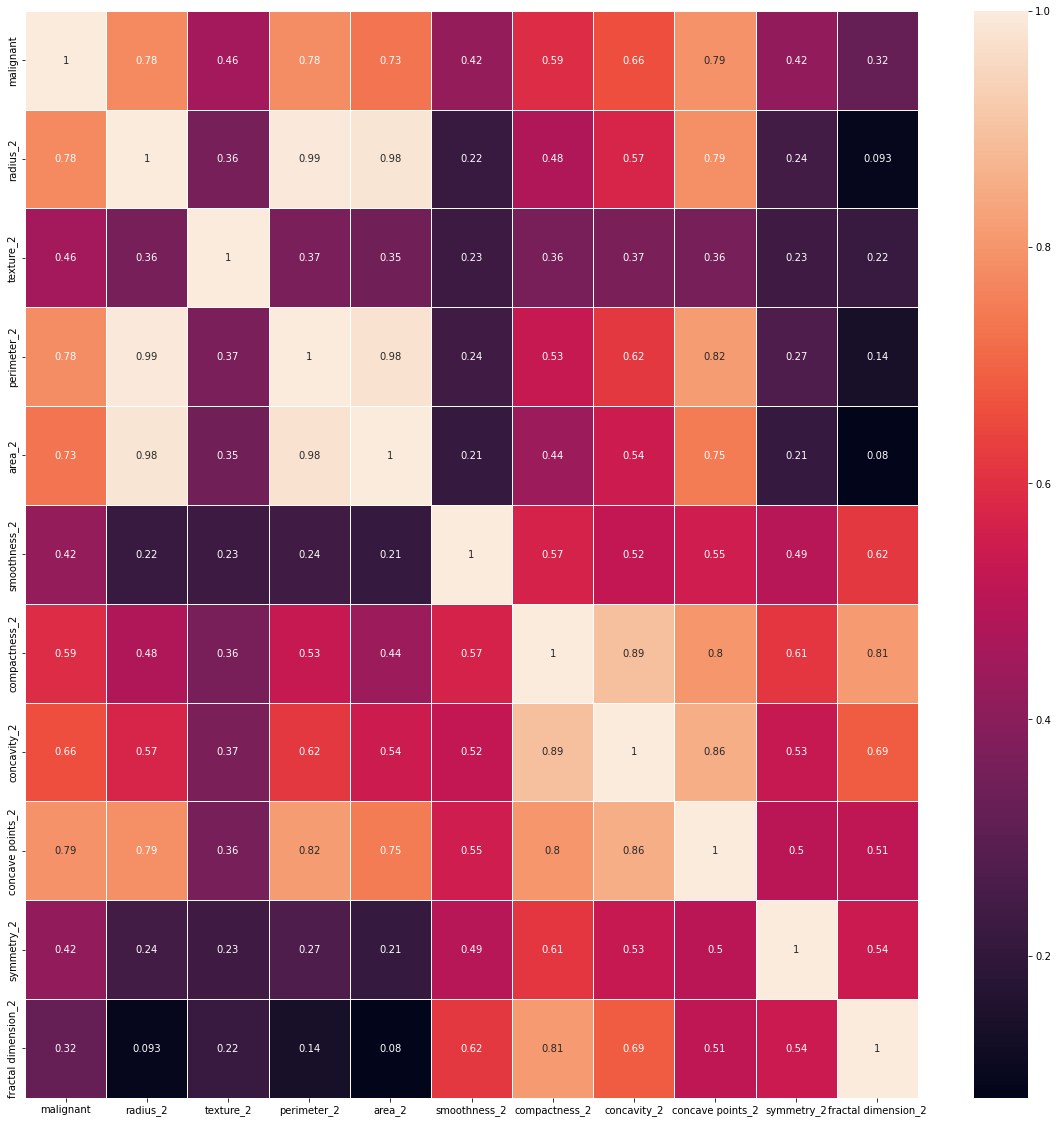

In [148]:
X = data[['malignant', 'radius_2', 'texture_2', 'perimeter_2', 'area_2', 'smoothness_2', 'compactness_2','concavity_2', 'concave points_2', 'symmetry_2', 'fractal dimension_2']]

print(X.columns)
fig, ax = plt.subplots(figsize=(20,20))         
cm_all_features = X.corr()
sn.heatmap(cm_all_features, annot=True, linewidths=.6, ax=ax)
plt.show()
